# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
cd input

/kaggle/input


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [16]:
Score=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.<br /><br />Try it.  It's a great product.<br /><br /> ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I tried to change my review to 4 stars, but I don't seem able to do that.  These are 3 oz cans of 4 different flavors of fish based catfood.  Chicken and rabbit are often more recommended for cats.  The first ingredient is fish broth, making it s

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.Try it.  It's a great product. ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I tried to change my review to 4 stars, but I don't seem able to do that.  These are 3 oz cans of 4 different flavors of fish based catfood.  Chicken and rabbit are often more recommended for cats.  The first ingredient is fish broth, making it somewhat high in moisture

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The orange and lemon peels make this tea very hippy Despite the initial oohing and ahing over the pretty blue flowers this is a regrettable purchase I was hoping for a stronger bergamot component than Twinings Earl Grey but instead I got something that seems very herbal Blech I disagree with the positive reviews 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:21<00:00, 2189.86it/s]


In [26]:
preprocessed_reviews[1500]

'orange lemon peels make tea hippy despite initial oohing ahing pretty blue flowers regrettable purchase hoping stronger bergamot component twinings earl grey instead got something seems herbal blech disagree positive reviews'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
    ## Similartly you can do preprocessing for review summary also.
    preprocessed_summary = []
    # tqdm is for printing the status bar
    for sentance in tqdm(final['Summary'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_summary.append(sentance.strip())

100%|██████████| 46071/46071 [00:19<00:00, 2411.66it/s]


In [28]:
preprocessed_reviews=np.array(preprocessed_reviews)
preprocessed_summary=np.array(preprocessed_summary)
x_train=[]
x_test=[]
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1):
    x_train.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1,preprocessed_reviews.shape[0]):
    x_test.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
y_train=Score[:int((Score.shape[0]*0.7))+1]
y_test=Score[int((Score.shape[0]*0.7))+1:]
print(len(x_train))
print(len(x_test))
print(y_train.shape)
print(y_test.shape)

32250
13821
(32250,)
(13821,)


In [29]:
x_train[1]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors wow make islickers'

In [30]:
for i in range(len(x_train)):
        x_train[i] = x_train[i].split()

In [31]:
new_x_train=[]
for i in tqdm(range(len(x_train))):
  new_x_train=new_x_train+(x_train[i])

100%|██████████| 32250/32250 [05:28<00:00, 98.03it/s] 


In [32]:
#Generating list of vocalbulary 
vocab=[]
for i in tqdm(new_x_train):
  if i not in vocab:
    vocab.append(i)

100%|██████████| 1366800/1366800 [01:09<00:00, 19634.13it/s]


In [33]:
#counting the frequencies of occurance 
freq=[]
for i in tqdm(range(0, len(vocab))):
  freq.append(new_x_train.count(vocab[i]))	

100%|██████████| 34433/34433 [11:42<00:00, 49.02it/s]


In [34]:
freq=np.array(freq)
e=1
final_x=np.ones(len(freq),dtype=int)
for i in tqdm(np.argsort(-freq)):
  final_x[i]=e
  e=e+1

100%|██████████| 34433/34433 [00:00<00:00, 1405981.99it/s]


In [35]:
final_x

array([   17,     3,   469, ..., 21635, 29466, 17555])

In [37]:
for sent in tqdm(range(len(x_train))):
  for i in range(len(x_train[sent])):
    x_train[sent][i]=final_x[vocab.index(x_train[sent][i])]
  

100%|██████████| 32250/32250 [01:13<00:00, 441.09it/s]


In [38]:
x_test=list(x_test)
for i in range(len(x_test)):
  x_test[i] = x_test[i].split()
new_x_test=[]
for i in tqdm(range(len(x_test))):
  new_x_test=new_x_test+(x_test[i])

100%|██████████| 13821/13821 [00:33<00:00, 406.87it/s]


In [39]:
for sent in tqdm(range(len(x_test))):
  for i in range(len(x_test[sent])):
    if x_test[sent][i] in vocab:
      x_test[sent][i]=final_x[vocab.index(x_test[sent][i])]
    else:
      x_test[sent][i]= 0

100%|██████████| 13821/13821 [01:00<00:00, 229.31it/s]


In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)


Using TensorFlow backend.


In [41]:
print(x_train[1])
print(type(x_train[1]))
print(len(x_train[1]))

[225, 744, 38, 1485, 656, 34, 9, 11, 21608, 776, 254, 8346, 2033, 370, 391, 2351, 3598, 3831, 8345, 26, 1348, 5621, 3831, 2492, 3819, 740, 1289, 183, 101, 576, 9, 5621, 1507, 11753, 2, 3136, 10863, 3168, 21556, 573, 31, 21856]
<class 'list'>
42


In [42]:
# truncate and/or pad input sequences
max_review_length = 300
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(32250, 300)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [43]:
# create the model
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
embedding_vecor_length = 50
model = Sequential()
model.add(Embedding(len(vocab), embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 50)           1721650   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 64)           29440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)      

In [44]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=25,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 32250 samples, validate on 13821 samples
Epoch 1/10
32250/32250 [==============================] - 1119s 35ms/step - loss: 0.2357 - acc: 0.9070 - val_loss: 0.2293 - val_acc: 0.9012
Epoch 2/10
32250/32250 [==============================] - 1143s 35ms/step - loss: 0.1191 - acc: 0.9562 - val_loss: 0.2154 - val_acc: 0.9185
Epoch 3/10
32250/32250 [==============================] - 1119s 35ms/step - loss: 0.0723 - acc: 0.9741 - val_loss: 0.3318 - val_acc: 0.8918
Epoch 4/10
32250/32250 [==============================] - 1112s 34ms/step - loss: 0.0441 - acc: 0.9846 - val_loss: 0.2679 - val_acc: 0.9273
Epoch 5/10
32250/32250 [==============================] - 1117s 35ms/step - loss: 0.0295 - acc: 0.9909 - val_loss: 0.3137 - val_acc: 0.9219
Epoch 6/10
32250/32250 [==============================] - 1120s 35ms/step - loss: 0.0209 - acc: 0.9932 - val_loss: 0.3156 - val_acc: 0.9212
Epoch 7/10
32250/32250 [==============================] - 1133s 35ms/step - loss: 0.0191 - acc: 0.9936 - val_l

Test score: 0.403886510197915
Test accuracy: 0.9199044931237651


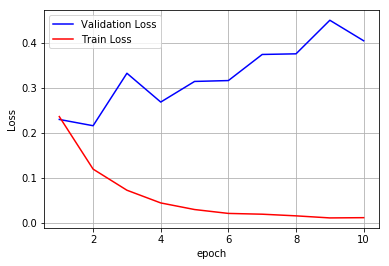

In [46]:
import numpy as np
import matplotlib.pyplot as plt
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt.plot(x, vy, 'b', label="Validation Loss")
plt.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid()


###### Conclusion

The model seems to over fit, hecne create another model with high droup out and lower units in he 2nd lstm layer

In [47]:
# create the model
from keras.layers import Dropout
embedding_vecor_length = 50
model = Sequential()
model.add(Embedding(len(vocab), embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.9))
model.add(LSTM(15))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 50)           1721650   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 32)           10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15)                2880      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 1,735,170
Trainable params: 1,735,170
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=30,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 32250 samples, validate on 13821 samples
Epoch 1/10
32250/32250 [==============================] - 1010s 31ms/step - loss: 0.2341 - acc: 0.9101 - val_loss: 0.1687 - val_acc: 0.9337
Epoch 2/10
32250/32250 [==============================] - 982s 30ms/step - loss: 0.1193 - acc: 0.9574 - val_loss: 0.1861 - val_acc: 0.9339
Epoch 3/10
32250/32250 [==============================] - 954s 30ms/step - loss: 0.0746 - acc: 0.9751 - val_loss: 0.2112 - val_acc: 0.9277
Epoch 4/10
32250/32250 [==============================] - 979s 30ms/step - loss: 0.0514 - acc: 0.9834 - val_loss: 0.2637 - val_acc: 0.9252
Epoch 5/10
32250/32250 [==============================] - 982s 30ms/step - loss: 0.0381 - acc: 0.9873 - val_loss: 0.2872 - val_acc: 0.9248
Epoch 6/10
32250/32250 [==============================] - 981s 30ms/step - loss: 0.0301 - acc: 0.9900 - val_loss: 0.3052 - val_acc: 0.9187
Epoch 7/10
32250/32250 [==============================] - 984s 31ms/step - loss: 0.0211 - acc: 0.9932 - val_loss: 0

Test score: 0.4287368161281373
Test accuracy: 0.917227407615632


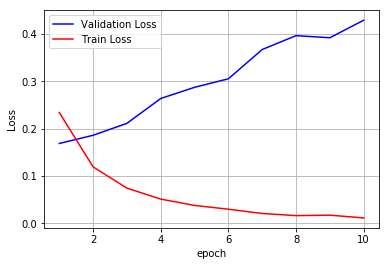

In [49]:
import numpy as np
import matplotlib.pyplot as plt
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt.plot(x, vy, 'b', label="Validation Loss")
plt.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid()


###### Conclusion

There seems to be some improvent but it is still overfitting after 2 epochs, hence try reducing the units in the lstm layer and test what happens when we also reduce embedding_vecor_length

In [50]:
# create the model
from keras.layers import Dropout
embedding_vecor_length = 25
model = Sequential()
model.add(Embedding(len(vocab), embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(12,return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(6))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 25)           860825    
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 12)           1824      
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 12)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 863,112
Trainable params: 863,112
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 32250 samples, validate on 13821 samples
Epoch 1/10
32250/32250 [==============================] - 455s 14ms/step - loss: 0.3040 - acc: 0.8891 - val_loss: 0.1986 - val_acc: 0.9249
Epoch 2/10
32250/32250 [==============================] - 451s 14ms/step - loss: 0.1428 - acc: 0.9504 - val_loss: 0.1865 - val_acc: 0.9302
Epoch 3/10
32250/32250 [==============================] - 451s 14ms/step - loss: 0.0939 - acc: 0.9702 - val_loss: 0.2136 - val_acc: 0.9278
Epoch 4/10
32250/32250 [==============================] - 449s 14ms/step - loss: 0.0649 - acc: 0.9799 - val_loss: 0.2409 - val_acc: 0.9263
Epoch 5/10
32250/32250 [==============================] - 450s 14ms/step - loss: 0.0472 - acc: 0.9874 - val_loss: 0.2505 - val_acc: 0.9247
Epoch 6/10
32250/32250 [==============================] - 454s 14ms/step - loss: 0.0356 - acc: 0.9903 - val_loss: 0.3064 - val_acc: 0.9213
Epoch 7/10
32250/32250 [==============================] - 452s 14ms/step - loss: 0.0295 - acc: 0.9917 - val_loss: 0.

Test score: 0.363516823457301
Test accuracy: 0.9154909196237038


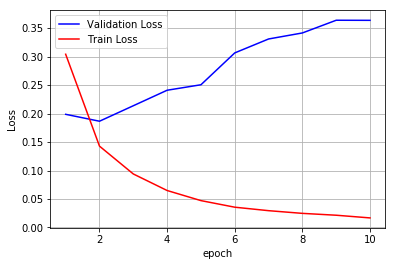

In [52]:
import numpy as np
import matplotlib.pyplot as plt
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt.plot(x, vy, 'b', label="Validation Loss")
plt.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid()


##### Conclusion 

It can be seen from the above graph that the model-3 also  started over fitting from 2nd epoch 